## **The notebook shows the baseline implementation for the Rhetorical Labeling Classification task.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import re
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 28.0 MB/s eta 0:00:00


In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
bert_model = AutoModel.from_pretrained("law-ai/InLegalBERT",output_hidden_states=True)
bert_model = bert_model.to('cuda')

# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
# bert_model = bert_model.to('cuda')

Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def numpyarray(sent):
  granola_ids = tokenizer.encode(sent, max_length=100)
  granola_ids = torch.LongTensor(granola_ids)
  granola_ids = granola_ids.to(device)
  # print(granola_ids.shape)
  bert_model.eval()
  granola_ids = granola_ids.unsqueeze(0)
  # print(granola_ids.shape)
  with torch.no_grad():
    out = bert_model(input_ids=granola_ids)
    # print(out[0].shape)
  hidden_states = out[2]
  sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
  # print(sentence_embedding.shape)
  np_tensor = sentence_embedding.cpu().numpy()
  return np_tensor


In [12]:
f = open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_train.json")

data = json.load(f)
print("Total training samples provided by the organizers: ", len(data))

AllText=[]
for i in range(len(data)):
    TempText=[]
    if len(data[i]['annotations'][0]['result'])!=0: 

        for j in range(len(data[i]['annotations'][0]['result'])):
            TempText.append(data[i]['annotations'][0]['result'][j]['value']['text'])
        AllText.append(TempText)


CleanedText=[]
for i in range(len(AllText)):
    TempCleanedText=[]
    for j in range(len(AllText[i])):
        AllText[i][j]=AllText[i][j].replace("\n"," ")
        AllText[i][j]=re.sub('\s+',' ',AllText[i][j])
        AllText[i][j]=AllText[i][j].lower()
        TempCleanedText.append(AllText[i][j])
    CleanedText.append(TempCleanedText)  
print("After cleaning, total number of samples in training data (documentwise): ", len(CleanedText))

AllLabels=[]
for i in range(len(data)):
    TempLabels=[]
    if len(data[i]['annotations'][0]['result'])!=0:
        for j in range(len(data[i]['annotations'][0]['result'])):
            TempLabels.append(data[i]['annotations'][0]['result'][j]['value']['labels'][0])
        AllLabels.append(TempLabels)
    
for i in range(len(AllLabels)):
    for j in range(len(AllLabels[i])):
        AllLabels[i][j]=AllLabels[i][j].lower()    
print("After cleaning, total number of labels in training data (documentwise): ", len(AllLabels)) 

SentwiseCleanedText=[]
for i in range(len(CleanedText)):
  for j in range(len(CleanedText[i])):
      SentwiseCleanedText.append(CleanedText[i][j])

SentwiseLabels=[]
for i in range(len(AllLabels)):
  for j in range(len(AllLabels[i])):
      SentwiseLabels.append(AllLabels[i][j])

print("Total number of sentences in training data: ", len(SentwiseCleanedText))
print("Total number of labels in the training data: ", len(SentwiseLabels))

Total training samples provided by the organizers:  247
After cleaning, total number of samples in training data (documentwise):  245
After cleaning, total number of labels in training data (documentwise):  245
Total number of sentences in training data:  28986
Total number of labels in the training data:  28986


In [ ]:
# analysis          10695
# arg_petitioner     1315
# arg_respondent      698
# fac                5744
# issue               367
# none               1423
# pre_not_relied      158
# pre_relied         1431
# preamble           4167
# ratio               674
# rlc                 752
# rpc                1081
# sta                 481

In [13]:
f = open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_dev.json")

val_data = json.load(f)
print("Total validation samples provided by the organizers: ", len(val_data))

DevText=[]
for i in range(len(val_data)):
    TempText=[]
    for j in range(len(val_data[i]['annotations'][0]['result'])):
        TempText.append(val_data[i]['annotations'][0]['result'][j]['value']['text'])
    DevText.append(TempText)


CleanedDevText=[]
for i in range(len(DevText)):
    TempCleanedText=[]
    for j in range(len(DevText[i])):
        DevText[i][j]=DevText[i][j].replace("\n"," ")
        DevText[i][j]=re.sub('\s+',' ',DevText[i][j])
        DevText[i][j]=DevText[i][j].lower()
        TempCleanedText.append(DevText[i][j])
    CleanedDevText.append(TempCleanedText)  

AllDevLabels=[]
for i in range(len(val_data)):
    TempLabels=[]
    for j in range(len(val_data[i]['annotations'][0]['result'])):
        TempLabels.append(val_data[i]['annotations'][0]['result'][j]['value']['labels'][0])
    AllDevLabels.append(TempLabels)
    
for i in range(len(AllDevLabels)):
    for j in range(len(AllDevLabels[i])):
        AllDevLabels[i][j]=AllDevLabels[i][j].lower()   

print("After cleaning, total number of samples in validation data (documentwise): ", len(CleanedDevText))
print("After cleaning, total number of labels in validation data (documentwise): ", len(AllDevLabels))

SentwiseDevLabels=[]
for i in range(len(AllDevLabels)):
  for j in range(len(AllDevLabels[i])):
      SentwiseDevLabels.append(AllDevLabels[i][j])  

print("Total number of sentences in validation data: ", len(SentwiseDevLabels))

Total validation samples provided by the organizers:  30
After cleaning, total number of samples in validation data (documentwise):  30
After cleaning, total number of labels in validation data (documentwise):  30
Total number of sentences in validation data:  2879


In [14]:
encoded_labels=[]
from sklearn.preprocessing import LabelEncoder

label_enc= LabelEncoder()
label_enc.fit(SentwiseLabels)

y_tr=label_enc.transform(SentwiseLabels)
y_val=LabelEncoder().fit_transform(SentwiseDevLabels)

With the help of code given below, we are creating numerical vector of each sentence of a document. This block of code needs to be run for once. Once we have csv file containing the numerical vectors along with their labels, we can utilize this while training.

In [ ]:
# import csv
# import numpy as np
# for j in range(len(SentwiseCleanedText)):
	
# 	if j%1000==0:
# 		print(j)
# 	with open('/content/drive/My Drive/Colab Notebooks/LegalEval/LegalEval_RR_valid_embeddings_indian_legal_bert.csv', 'a+', newline='',encoding='utf-8') as write_obj:
# 		# Create a writer object from csv module
# 		csv_writer = csv.writer(write_obj, quoting= csv.QUOTE_NONNUMERIC)
# 		# Add contents of list as last row in the csv file
# 		csv_writer.writerow(np.append(numpyarray(SentwiseCleanedText[j]),[SentwiseLabels[j]]))

# 	write_obj.close()

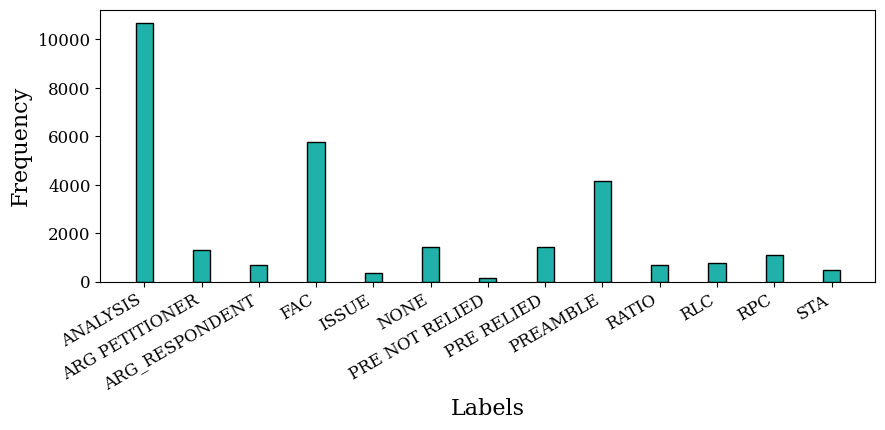

In [15]:
import numpy as np
import matplotlib.pyplot as plt

data={'ANALYSIS':10695,'ARG PETITIONER':1315 ,'ARG_RESPONDENT':698,'FAC':5744 ,'ISSUE':367 ,'NONE':1423, 'PRE NOT RELIED':158, 'PRE RELIED':1431, 
'PREAMBLE':4167, 'RATIO':674,'RLC':752, 'RPC':1081, 'STA':481}

# data = {'Baseline': 0.6160, 'Model1':0.7419, 'Model2':0.725,'Model3':0.7368, 'Model4':0.7201}
labels = list(data.keys())
freqs = list(data.values())
  
fig = plt.figure(figsize = (10,4))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams.update({'font.family':'DejaVu Serif'})
# creating the bar plot
plt.bar(labels, freqs, color ='#20B2AA',edgecolor= 'black', width = 0.3)
 
plt.xlabel("Labels", fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(ymin=150,ymax=10900)
fig.autofmt_xdate()

plt.show()

# plt.title("Students enrolled in different courses")
# plt.savefig('Freq.eps', format='eps',bbox_inches='tight')

In [ ]:
# label_dict= {0: 'ANALYSIS', 1: 'ARG_PETITIONER', 2:'ARG_RESPONDENT', 3: 'FAC',4:'ISSUE', 
#              5: 'NONE',6:'PRE_NOT_RELIED',7:'PRE_RELIED',8: 'PREAMBLE', 9:'RATIO',
#              10:'RLC', 11: 'RPC', 12: 'STA'}

The code below gives the weight to each of the class. One can utilize this to somehow deal with the problem of class imbalance. In our baseline model, we did not use it because we did not observe much improvement.

In [ ]:
# import numpy as np
# import math

# # labels_dict : {ind_label: count_label}
# # mu : parameter to tune 

# def create_class_weight(labels_dict,mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# # random labels_dict
# labels_dict = {0: 10695, 1: 1315, 2: 698, 3: 5744, 4: 367, 5: 1423, 6: 158, 7: 1431, 8: 4167, 9:674, 10: 752, 11: 1081, 12: 481}

# class_weight=create_class_weight(labels_dict)


In [16]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/LegalEval_RR_train_embeddings_indian_legal_bert.csv',header=None)
Y = df[768].tolist()
df.drop(768, axis=1, inplace=True)
df=df.values.tolist()

In [17]:
df_val=pd.read_csv('/content/drive/My Drive/Colab Notebooks/LegalEval/LegalEval_RR_valid_embeddings_indian_legal_bert.csv',header=None)
Y_val = df_val[768].tolist()
df_val.drop(768, axis=1, inplace=True)
df_val=df_val.values.tolist()

In [18]:
df=np.asarray(df)
df_val=np.asarray(df_val)
print(df.shape)
print(df_val.shape)
print(y_tr.shape)
print(y_val.shape)

(28986, 768)
(2879, 768)
(28986,)
(2879,)


*Multi-layer perceptron (MLP) model utilize for training*

In [19]:
inputA= Input(shape=(df.shape[1],))
x=  Dense(2048, activation="relu")(inputA)
x=Dropout(0.6)(x)
x=Dense(1024,activation="relu")(x)
x=Dropout(0.6)(x)
x=Dense(units=13, activation='softmax')(x)
model= Model(inputs=inputA, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 2048)              1574912   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 13)                13325     
                                                                 
Total params: 3,686,413
Trainable params: 3,686,413
Non-train

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
history=model.fit(df, y_tr, validation_data=(df_val,y_val),epochs =500,callbacks=[es], batch_size= 32)

Epoch 1/500
906/906 [==============================] - 11s 6ms/step - loss: 1.4358 - accuracy: 0.5418 - val_loss: 1.2039 - val_accuracy: 0.6276
Epoch 2/500
906/906 [==============================] - 4s 4ms/step - loss: 1.2490 - accuracy: 0.5926 - val_loss: 1.1804 - val_accuracy: 0.6336
Epoch 3/500
906/906 [==============================] - 3s 4ms/step - loss: 1.2002 - accuracy: 0.6059 - val_loss: 1.2254 - val_accuracy: 0.6249
Epoch 4/500
906/906 [==============================] - 4s 4ms/step - loss: 1.1658 - accuracy: 0.6144 - val_loss: 1.1582 - val_accuracy: 0.6283
Epoch 5/500
906/906 [==============================] - 6s 7ms/step - loss: 1.1524 - accuracy: 0.6218 - val_loss: 1.1748 - val_accuracy: 0.6429
Epoch 6/500
906/906 [==============================] - 4s 5ms/step - loss: 1.1242 - accuracy: 0.6269 - val_loss: 1.1665 - val_accuracy: 0.6450
Epoch 7/500
906/906 [==============================] - 6s 7ms/step - loss: 1.1069 - accuracy: 0.6303 - val_loss: 1.1614 - val_accuracy: 0.624

In [ ]:
# model.save('/content/drive/My Drive/Colab Notebooks/LegalEval/model2_INDIANLEGALBERT.h5')

In [ ]:
# import keras
# model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/LegalEval/model2_INDIANLEGALBERT.h5')

In [25]:
y_prob=model.predict(df_val)
flat_pred=np.argmax(y_prob,axis=1)


90/90 [==============================] - 0s 2ms/step


In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Classification Report:')
print(classification_report(flat_pred, y_val, digits=4))
from sklearn import metrics
print(metrics.accuracy_score(y_val, flat_pred))

Classification Report:
              precision    recall  f1-score   support

           0     0.8577    0.5509    0.6709      1532
           1     0.1714    0.3077    0.2202        39
           2     0.0000    0.0000    0.0000         0
           3     0.5879    0.6545    0.6194       521
           4     0.7000    0.7292    0.7143        48
           5     0.8211    0.8478    0.8342       184
           6     0.0000    0.0000    0.0000         0
           7     0.2254    0.7442    0.3459        43
           8     0.5492    0.8558    0.6691       326
           9     0.0143    1.0000    0.0282         1
          10     0.1638    0.4750    0.2436        40
          11     0.7692    0.6667    0.7143       105
          12     0.7143    0.5000    0.5882        40

    accuracy                         0.6283      2879
   macro avg     0.4288    0.5640    0.4345      2879
weighted avg     0.7351    0.6283    0.6559      2879

0.6283431747134421


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

print(precision_score(y_val,flat_pred, average='weighted'))
print(recall_score(y_val,flat_pred, average='weighted'))
print(f1_score(y_val,flat_pred, average='weighted'))

print(precision_score(y_val,flat_pred, average='micro'))
print(recall_score(y_val,flat_pred, average='micro'))
print(f1_score(y_val,flat_pred, average='micro'))

print(precision_score(y_val,flat_pred, average='macro'))
print(recall_score(y_val,flat_pred, average='macro'))
print(f1_score(y_val,flat_pred, average='macro'))


0.6533521752039056
0.6283431747134421
0.6008276965537246
0.6283431747134421
0.6283431747134421
0.6283431747134421
0.5639838761611287
0.42879198669829055
0.43448671812041195


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


During testing phase, we utilized the code written below in order to make a submission.

In [28]:
#For creating the document wise embeddings.
def bert_embeds(doc):
    
  np_tensor=[]
  for i in range(len(doc)):

    granola_ids = tokenizer.encode(doc[i], max_length=100)
    granola_ids = torch.LongTensor(granola_ids)
    granola_ids = granola_ids.to(device)
    bert_model.eval()
    granola_ids = granola_ids.unsqueeze(0)
    with torch.no_grad():
      out = bert_model(input_ids=granola_ids)
    hidden_states = out[2]
    sentence_embedding = torch.mean(hidden_states[-1], dim=1).squeeze()
    np_tensor.append(sentence_embedding.cpu().numpy())
  return np_tensor

In [29]:
import re
from sklearn.metrics import precision_recall_fscore_support
def pred_probs(doc):
    bert_embedding=bert_embeds(doc)
#     print(bert_embedding[0].shape)
    y_prob=model.predict(np.asarray(bert_embedding))
    flat_pred=np.argmax(y_prob,axis=1).flatten()
    flat_pred_list= flat_pred.tolist()
    # label_list=[]
    # for key in flat_pred_list:
    #     label_list.append(label_dict[key])
    y_pred_string =label_enc.inverse_transform(flat_pred)
    label= y_pred_string.tolist()
    
# print(label)
    
    return label
    
    

In [30]:
total_prob=[]
for i in range(len(CleanedDevText)):
    print(i)
    total_prob.append(pred_probs(CleanedDevText[i]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0
3/3 [==============================] - 0s 3ms/step
1
5/5 [==============================] - 0s 3ms/step
2
5/5 [==============================] - 0s 2ms/step
3
2/2 [==============================] - 0s 5ms/step
4
3/3 [==============================] - 0s 7ms/step
5
2/2 [==============================] - 0s 5ms/step
6
3/3 [==============================] - 0s 3ms/step
7
4/4 [==============================] - 0s 3ms/step
8
7/7 [==============================] - 0s 2ms/step
9
5/5 [==============================] - 0s 3ms/step
10
3/3 [==============================] - 0s 5ms/step
11
4/4 [==============================] - 0s 4ms/step
12
7/7 [==============================] - 0s 2ms/step
13
5/5 [==============================] - 0s 2ms/step
14
2/2 [==============================] - 0s 5ms/step
15
2/2 [==============================] - 0s 5ms/step
16
4/4 [==============================] - 0s 3ms/step
17
4/4 [==============================] - 0s 4ms/step
18
2/2 [==============================

In [31]:
for i in range(len(total_prob)):
  for j in range(len(total_prob[i])):
    total_prob[i][j]=total_prob[i][j].upper()

In [33]:
# for i in range(len(total_prob)):
#   for j in range(len(total_prob[i])):
#     print(f'Indices: {i},{j}')
#     test_data[i]['annotations'][0]['result'][j]['value']['labels'][0] = total_prob[i][j]
#     print(test_data[i]['annotations'][0]['result'][j]['value']['labels'][0])
    

In [ ]:
# with open("/content/drive/My Drive/Colab Notebooks/LegalEval/RR_TEST_DATA_FS_With_Legal_BERT_SentwisePredictions.json", "w") as outfile:
#     json.dump(test_data, outfile)